# Merge SWOT and S2 ice mask

In [4]:
import pandas as pd
import numpy as np

import rasterio
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime

## One file test

### Prep SWOT data

In [3]:
# SWOT_df = pd.read_pickle("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC.pkl")

# load in the reprojected & filtered SWOT obs
SWOT_df = pd.read_csv("../SWOT_reprojected.csv")

# # column names
# print(SWOT_df.columns)
# # shape
# print(SWOT_df.shape)

In [4]:
# drop lat lon columns now that we are in UTMs
SWOT_df = SWOT_df.drop(columns=["longitude", "latitude"])

# convert timestamps to datetime objects
SWOT_df['time_granule_start'] = pd.to_datetime(SWOT_df['time_granule_start'])

In [5]:
# Create a normalized elevation column based on grouped cycle, pass, and time information

# Confirm elevation is numeric
SWOT_df['elevation'] = pd.to_numeric(SWOT_df['elevation'], errors='coerce')

# Function to return normalized values between 0 and 1
def _group_minmax(series):
    mn = series.min()
    mx = series.max()
    # if values are NaN keep them NaN
    if pd.isna(mn) and pd.isna(mx):
        return pd.Series(np.nan, index=series.index)
    # if constant group (mx == mn), don't normalize and set to NaN (this shouldn't happen tho)
    if mx == mn:
        return pd.Series(np.nan, index=series.index)
    return (series - mn) / (mx - mn)

# Create the normalized elevation
SWOT_df['elevation_normalized'] = (SWOT_df
    .groupby(['cycle_number', 'pass_number', 'time_granule_start'])['elevation'] # group by cycle, pass, & time
    .transform(_group_minmax) # normalize!
)

In [6]:
SWOT_df.head(5)

,phase_noise_std,waterfrac,geolocqual,sig0,sig0_uncert,crosstrack,elevation,cycle_number,pass_number,tile_number,time_granule_start,source_file,x_utm,y_utm,elevation_normalized
0,0.045659,0.167256,0,24.465372,11.847507,-13393.489,296.291781,35,52,30,2025-07-01 10:55:09.367570,SWOT_L2_HR_PIXC_035_052_030L_20250701T105509_2...,399038.951495,7.682782e+06,0.276523
1,0.031159,1.224904,0,322.846560,151.669880,-13441.603,295.972732,35,52,30,2025-07-01 10:55:09.367570,SWOT_L2_HR_PIXC_035_052_030L_20250701T105509_2...,399060.180569,7.682796e+06,0.275821
2,0.026563,2.583732,0,965.866940,452.993770,-13492.629,295.815024,35,52,30,2025-07-01 10:55:09.367570,SWOT_L2_HR_PIXC_035_052_030L_20250701T105509_2...,399089.299183,7.682815e+06,0.275473
3,0.022460,1.348676,0,588.309800,276.064580,-13541.679,295.813125,35,52,30,2025-07-01 10:55:09.367570,SWOT_L2_HR_PIXC_035_052_030L_20250701T105509_2...,399125.970729,7.682839e+06,0.275469
4,0.023962,0.945739,0,326.267850,153.267000,-13596.973,295.896783,35,52,30,2025-07-01 10:55:09.367570,SWOT_L2_HR_PIXC_035_052_030L_20250701T105509_2...,399166.699746,7.682866e+06,0.275653


In [ ]:
# this block is taking forever on the docker
# so we ran it locally ...

# # Create gdf with geometry from longitude/latitude
# gdf = gpd.GeoDataFrame(
#     SWOT_df,
#     geometry=gpd.points_from_xy(SWOT_df['longitude'], SWOT_df['latitude']),
#     crs="EPSG:4326"  # this is a close enough realization for now...
# )

# # UTM zone 6N
# gdf_reprojected = gdf.to_crs(epsg=32606)

# # Add reprojected coordinates to a new DataFrame
# SWOT_reprojected_df = SWOT_df.copy()
# SWOT_reprojected_df["x_utm"] = gdf_reprojected.geometry.x
# SWOT_reprojected_df["y_utm"] = gdf_reprojected.geometry.y

### Prep S2 ice mask data

In [ ]:
# list of ones i've looked at
# poly_01_20250719_snow.tif

In [6]:
# ------------ load snow mask data ------------

# filepath
filepath = "../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif"
snowmask_src = rasterio.open(filepath)

# Read band 1
snowmask_20250603 = snowmask_src.read(1)


In [12]:
# %%bash
# # gdalinfo to check metadata
# gdalinfo ../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif
# # CRS is "WGS 84 / UTM zone 6N"

In [13]:
# %%bash
# gdalwarp -r bilinear -overwrite -t_srs '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' ../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif ../../../../shared_space/SWOT_Aufeis/snow_mask/snow_mask_latlon/poly_01_20250719_snow.tif  

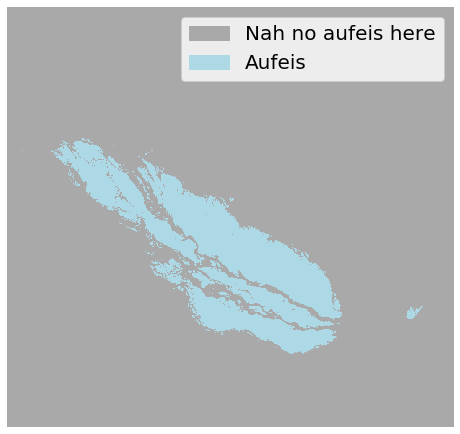

In [7]:
# plot the ice mask!

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Colormap: 0 = dark gray, 1 = light blue
cmap = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(snowmask_20250603, cmap=cmap, norm=norm)
plt.axis('off')
legend_patches = [mpatches.Patch(color='darkgray', label='Nah no aufeis here'),
    mpatches.Patch(color='lightblue', label='Aufeis')]
plt.legend(handles=legend_patches, loc='upper right', frameon=True, fontsize=20)
plt.show()

## Single file join

### Match in time

In [15]:
# Extract the S2 ice mask date

# get just the filename
filename = os.path.basename(filepath)
# Extract the YYYYMMDD part
date_str = filename.split("_")[2]  

# Convert to datetime.date
icemask_date = datetime.strptime(date_str, "%Y%m%d").date()
icemask_date

datetime.date(2025, 7, 19)

In [16]:
# filter to the correct date
SWOT_df_20250719 = SWOT_df[SWOT_df['time_granule_start'].dt.date == icemask_date]


In [17]:
# SWOT_df_20250719

In [18]:
from rasterio.transform import rowcol

# get raster transform & shape
transform = snowmask_src.transform
height, width = snowmask_20250603.shape

# make a safe copy to avoid SettingWithCopyWarning
SWOT_df_20250719 = SWOT_df_20250719.copy()

# compute row/col for each SWOT pixel
rows, cols = rowcol(transform,
                    SWOT_df_20250719["x_utm"].values,
                    SWOT_df_20250719["y_utm"].values)

# convert to numpy arrays
rows = np.array(rows, dtype=int)
cols = np.array(cols, dtype=int)

# mask of what pixels are in bounds of the raster
in_bounds = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)

# create an array of NaNs then fill in-bounds values from the raster
ice_vals = np.full(len(rows), np.nan, dtype=float)
if in_bounds.any():
    ice_vals[in_bounds] = snowmask_20250603[rows[in_bounds], cols[in_bounds]]

In [19]:
# join ice mask to the SWOT dataframe
SWOT_df_20250719["ice_mask"] = ice_vals  # NaN = outside raster; otherwise 0 or 1

# only keep SWOT pixels inside the raster
SWOT_df_20250719_overlap = SWOT_df_20250719[~SWOT_df_20250719["ice_mask"].isna()].copy()

# convert ice_mask to integer 0/1
SWOT_df_20250719_overlap["ice_mask"] = SWOT_df_20250719_overlap["ice_mask"].astype(int)

# some quick checks
print("All points (before spatial filter):", len(SWOT_df_20250719))
print("Points overlapping raster footprint:", len(SWOT_df_20250719_overlap))
SWOT_df_20250719_overlap.head()

All points (before spatial filter): 648030
Points overlapping raster footprint: 24029


,phase_noise_std,waterfrac,geolocqual,sig0,sig0_uncert,crosstrack,elevation,cycle_number,pass_number,tile_number,time_granule_start,source_file,x_utm,y_utm,elevation_normalized,ice_mask
822949,0.036112,0.191685,0,2.505438,1.320719,-50125.832,418.125891,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472381.972125,7.683366e+06,0.298034,0
822950,0.030306,0.513329,0,7.407903,3.619110,-50137.773,417.951496,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472374.526080,7.683372e+06,0.297732,0
822951,0.022068,0.705059,0,12.915502,6.201205,-50149.730,417.760237,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472367.298752,7.683377e+06,0.297400,0
822952,0.030209,0.866819,0,14.735769,7.054668,-50161.574,417.536564,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472360.491691,7.683381e+06,0.297013,0
822953,0.036771,0.244385,0,4.446941,2.231380,-50173.420,417.470195,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472351.654988,7.683388e+06,0.296898,0


In [20]:
# look at counts
ice_count = (SWOT_df_20250719_overlap['ice_mask'] == 1).sum()
no_ice_count = (SWOT_df_20250719_overlap['ice_mask'] == 0).sum()

print("Aufeis (1):", ice_count)
print("Nah nah nope (0):", no_ice_count)

Aufeis (1): 1993
Nah nah nope (0): 22036


In [20]:
# save as a csv

output_csv = "../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_SWOT_icemask.csv"

SWOT_df_20250719_overlap.to_csv(output_csv, index=False)

# HERE IS HOW TO PLOT SWOT & RASTER TOGETHER

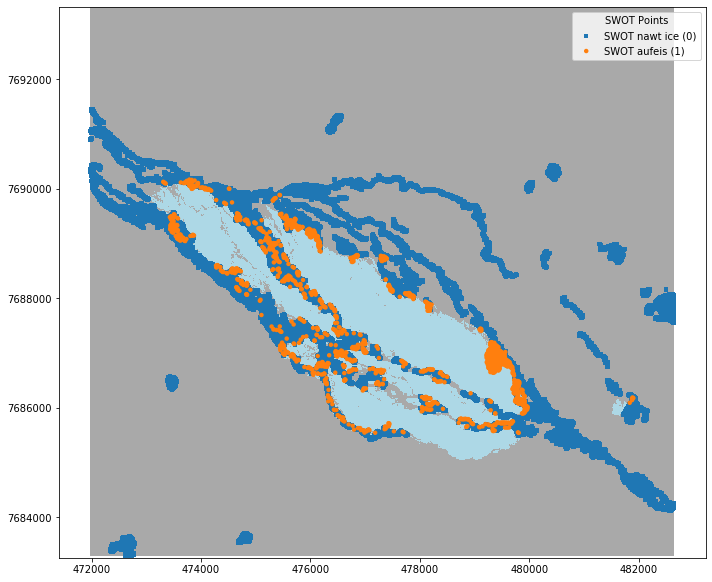

In [36]:
# plot to check!
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


# colormap and norm (0 = dark gray, 1 = light blue)
cmap = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Mask NaNs so they plot transparent
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)

# compute georeferenced extent: (minx, miny, maxx, maxy)
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(
    height, width, snowmask_src.transform
)
extent = (minx, maxx, miny, maxy)

# ok actual plotting now
fig, ax = plt.subplots(figsize=(10, 10))

# plot ice mask raster
im = ax.imshow(
    raster_to_plot, cmap=cmap, norm=norm,
    extent=extent, origin='upper', interpolation='nearest'
)

# plot SWOT points
df = SWOT_df_20250719_overlap
mask_ice = df['ice_mask'] == 1
mask_noice = df['ice_mask'] == 0
mask_out = df['ice_mask'].isna()

point_handles = []  # store legend handles

if mask_noice.any():
    h_noice = ax.scatter(
        df.loc[mask_noice, 'x_utm'], df.loc[mask_noice, 'y_utm'],
        s=20, marker='s', label='SWOT nawt ice (0)', edgecolor='none'
    )
    point_handles.append(h_noice)

if mask_ice.any():
    h_ice = ax.scatter(
        df.loc[mask_ice, 'x_utm'], df.loc[mask_ice, 'y_utm'],
        s=20, marker='o', label='SWOT aufeis (1)', edgecolor='none'
    )
    point_handles.append(h_ice)

# Legend for SWOT points ONLY
ax.legend(handles=point_handles, loc='upper right', title="SWOT Points")

# Labels & aspect
# ax.set_xlabel('UTM X')
# ax.set_ylabel('UTM Y')
ax.set_aspect('equal', adjustable='box')

# plt.title("Snow mask (0 = dark gray, 1 = light blue) with SWOT points")
plt.tight_layout()
plt.show()


In [37]:
SWOT_df_20250719_overlap.head(5)

,phase_noise_std,waterfrac,geolocqual,sig0,sig0_uncert,crosstrack,elevation,cycle_number,pass_number,tile_number,time_granule_start,source_file,x_utm,y_utm,elevation_normalized,ice_mask
822949,0.036112,0.191685,0,2.505438,1.320719,-50125.832,418.125891,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472381.972125,7.683366e+06,0.298034,0
822950,0.030306,0.513329,0,7.407903,3.619110,-50137.773,417.951496,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472374.526080,7.683372e+06,0.297732,0
822951,0.022068,0.705059,0,12.915502,6.201205,-50149.730,417.760237,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472367.298752,7.683377e+06,0.297400,0
822952,0.030209,0.866819,0,14.735769,7.054668,-50161.574,417.536564,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472360.491691,7.683381e+06,0.297013,0
822953,0.036771,0.244385,0,4.446941,2.231380,-50173.420,417.470195,35,543,279,2025-07-19 00:37:14.527858,SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_2...,472351.654988,7.683388e+06,0.296898,0


In [49]:
SWOT_df_20250719_overlap.iloc[24000]['source_file']

'SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_20250719T003725_PID0_01.nc'

In [2]:
import xarray as xr
# ---------- Filepath ----------
aufeis_test_tile_filepath = "../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/SWOT_L2_HR_PIXC_035_543_279L_20250719T003714_20250719T003725_PID0_01.nc"

# NetCDF structure check
import netCDF4
data_structure = netCDF4.Dataset(aufeis_test_tile_filepath)
# print(data_structure) # shows 'groups: pixel_cloud, tvp, noise'

# file pointer
fp = xr.open_dataset(aufeis_test_tile_filepath, group = 'pixel_cloud')

In [7]:
# Extract the variables we want into 1D numpy arrays
def getvar(name):
    return fp[name].values.ravel() if name in fp else np.nan

# Build a Pandas DataFrame
SWOT_Points = pd.DataFrame({
    "longitude": getvar("longitude"),
    "latitude": getvar("latitude"),
    "height": getvar("height"),
#     "phase_noise_std": getvar("phase_noise_std"),
#     "dheight": getvar("dheight_dphase"),
#     "class": getvar("classification"),
#     "classqual": getvar("classification"),
#     "bright_land_flag": getvar("bright_land_flag"),
#     "ancillary_surface_classification_flag": getvar("ancillary_surface_classification_flag"),
#     "waterfrac": getvar("water_frac"),
#     "waterfrac_uncert": getvar("water_frac_uncert"),
#     "prior_water_prob": getvar("prior_water_prob"),
#     "geolocqual": getvar("geolocation_qual"),
    "sig0": getvar("sig0"),
#     "sig0_uncert": getvar("sig0_uncert"),
#     "sig0_qual": getvar("sig0_qual"),
    "crosstrack": getvar("cross_track"),
#     "pixel_area": getvar("pixel_area"),
#     "darea_dheight": getvar("darea_dheight"),
    # elevation corrections
    "geoid": getvar("geoid"),
    "solid_tide": getvar("solid_earth_tide"),
    "load_tide": getvar("load_tide_fes"),
    "pole_tide": getvar("pole_tide")
})

# Derive elevation & height uncertainty
# SWOT_Points["height_uncert"] = SWOT_Points["phase_noise_std"] * SWOT_Points["dheight"]
SWOT_Points["geoid_correction"] = SWOT_Points["geoid"] - SWOT_Points["solid_tide"] - SWOT_Points["load_tide"] - SWOT_Points["pole_tide"]
SWOT_Points["elevation"] = SWOT_Points["height"] - SWOT_Points["geoid_correction"]

# Drop any empty rows
SWOT_Points = SWOT_Points.dropna(how="all")

# # Quality filtering
# geolocqual_problem_bits = {
#     4, 4101, 5, 6, 4100, 4102, 524292, 524293, 524294, 524295,
#     528389, 528390, 7, 528388, 16777220, 17301508, 17305604,
#     528391, 4103
# }

SWOT_Points = SWOT_Points[
#     (~SWOT_Points["geolocqual"].isin(geolocqual_problem_bits)) &
    (SWOT_Points["crosstrack"].abs().between(10000, 60000))]

print(SWOT_Points.head())
fp.close()

     longitude   latitude       height      sig0    crosstrack     geoid  \
89 -147.464711  68.754480  1158.496216 -0.505940 -10762.581055  6.829065   
90 -147.465338  68.754637  1158.158447 -0.348767 -10762.681641  6.827197   
91 -147.467646  68.755214  1158.934204 -0.766207 -10762.782227  6.820316   
92 -147.473888  68.756774  1162.391357 -0.218351 -10762.881836  6.801664   
93 -147.474555  68.756941  1162.098755  2.373093 -10762.982422  6.799667   

    solid_tide  load_tide  pole_tide  geoid_correction    elevation  
89   -0.023411  -0.008711   0.001354          6.859833  1151.636353  
90   -0.023410  -0.008711   0.001354          6.857964  1151.300537  
91   -0.023407  -0.008710   0.001354          6.851080  1152.083130  
92   -0.023400  -0.008710   0.001354          6.832419  1155.558960  
93   -0.023399  -0.008709   0.001354          6.830421  1155.268311  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure elevation exists and drop rows missing lon/lat/elevation
df = SWOT_Points.dropna(subset=["longitude","latitude","elevation"]).copy()

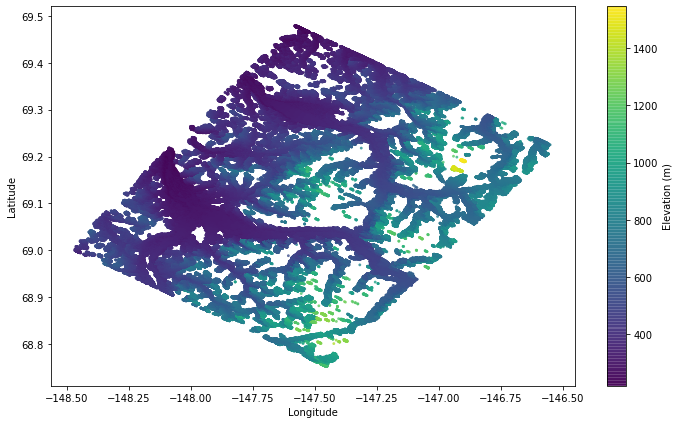

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(df["longitude"], df["latitude"],
                c=df["elevation"],        # color by elevation
                cmap="viridis",           # change to "terrain", "plasma", etc.
                s=8,                      # marker size
                alpha=0.8,
                linewidth=0)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_title("")
cbar = plt.colorbar(sc, ax=ax, label="Elevation (m)")
plt.tight_layout()
plt.show()